# Spatio-Temporal properties of chloride in dendrites

## Check python version, hot-reload files that change, and set width to screen width

In [1]:
#!conda install -n <env_name> <package>
!python2.7 -m pip install --upgrade pandas numpy scipy matplotlib --user

Requirement already up-to-date: pandas in /home/cbc/.local/lib/python2.7/site-packages (0.23.1)
Requirement already up-to-date: numpy in /home/cbc/.local/lib/python2.7/site-packages (1.14.5)
Requirement already up-to-date: scipy in /home/cbc/.local/lib/python2.7/site-packages (1.1.0)
Requirement already up-to-date: matplotlib in /home/cbc/.local/lib/python2.7/site-packages (2.2.2)
Requirement not upgraded as not directly required: python-dateutil>=2.5.0 in /home/cbc/.local/lib/python2.7/site-packages (from pandas) (2.6.1)
Requirement not upgraded as not directly required: pytz>=2011k in /home/cbc/.local/lib/python2.7/site-packages (from pandas) (2017.3)
Requirement not upgraded as not directly required: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /home/cbc/.local/lib/python2.7/site-packages (from matplotlib) (2.2.0)
Requirement not upgraded as not directly required: backports.functools-lru-cache in /home/cbc/.local/lib/python2.7/site-packages (from matplotlib) (1.4)
Requirement not upg

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
import sys
print(sys.version)
assert sys.version.split('|')[0][0]=='2', 'change kernel to python 2'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

2.7.12 (default, Dec  4 2017, 14:50:18) 
[GCC 5.4.0 20160609]


## Compile MOD files

In [3]:
!nrnivmodl

/home/cbc/dev/shunt-level
GABAa.mod HH2.mod KCC2.mod ampa.mod exfluct_simple.mod im.mod inhfluct_simple.mod kv.mod na.mod nmda_Tian.mod pasghk.mod
GABAa.mod HH2.mod KCC2.mod ampa.mod exfluct_simple.mod im.mod inhfluct_simple.mod kv.mod na.mod nmda_Tian.mod pasghk.mod
"/usr/local/nrn/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool"  --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  GABAa.lo HH2.lo KCC2.lo ampa.lo exfluct_simple.lo im.lo inhfluct_simple.lo kv.lo na.lo nmda_Tian.lo pasghk.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs -lnrnmpi -lscopmath -lsparse13 -lreadline -lncurses -L"/usr/local/nrn/x86_64/lib" "/usr/loc

In [4]:
!/usr/local/nrn/bin/nrnivmodl

/home/cbc/dev/shunt-level
GABAa.mod HH2.mod KCC2.mod ampa.mod exfluct_simple.mod im.mod inhfluct_simple.mod kv.mod na.mod nmda_Tian.mod pasghk.mod
GABAa.mod HH2.mod KCC2.mod ampa.mod exfluct_simple.mod im.mod inhfluct_simple.mod kv.mod na.mod nmda_Tian.mod pasghk.mod
"/usr/local/nrn/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool"  --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  GABAa.lo HH2.lo KCC2.lo ampa.lo exfluct_simple.lo im.lo inhfluct_simple.lo kv.lo na.lo nmda_Tian.lo pasghk.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs -lnrnmpi -lscopmath -lsparse13 -lreadline -lncurses -L"/usr/local/nrn/x86_64/lib" "/usr/loc

## Imports

In [5]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
%matplotlib notebook

# Morphologies

There is a single morphology used in these simulations akin to the morphology in Fig 4E from the paper `Principles Governing the Operation of Synaptic Inhibition in Dendrites`

The difference between the 2 classes is that `MultiDend` has mechanisms from `BaseNeuron`:
```
self.na = Mechanism('na', gbar=g_na_bar)
self.kv = Mechanism('kv', gbar=g_k_bar)
self.im = Mechanism('im', gkbar=g_im_bar)
self.pasghk = Mechanism('pasghk', gclpbar=g_pas_cl, gnapbar=g_pas_na, gkpbar=g_pas_k)
```

while `MultiDendSimple` has mechanism
* pas


| Fig 4E             | MultiDend (with 16 dendrites) |
|--------------------|-------------------------------|
|![Fig 4E](Fig4E.png)|![MultiDend.png](MultiDend.png)|



In [6]:
from nrnutils import Section, Mechanism, DISTAL, PROXIMAL
from baseneuron import BaseNeuron
logger = logging.getLogger('morphology')

# noinspection PyAttributeOutsideInit
class MultiDend(BaseNeuron):
    """
    Soma with [num_dendrites-1] projecting from it.
    Uses pasghk mechanism which sets the base vm from the im, na, kv, and (optionally) KCC2 channels
    """
    def __init__(self, name="MultiDend", num_dendrites=1, even_radial=False,
                 radial_l=50, radial_diam=2, radial_nseg=9,
                 *args, **kwargs):
        self.num_dendrites = num_dendrites
        self.radial = even_radial
        self.radial_L = radial_l
        self.radial_diam = radial_diam
        self.radial_nseg = radial_nseg
        super(MultiDend, self).__init__(name, call_geom_nseg=False, *args, **kwargs)

    def build_sections(self, axon=False, soma=False, **kwargs):
        super(MultiDend, self).build_sections(axon=axon,soma=soma,**kwargs)
        self.radial_dends = []
        if soma:
            parent=self.soma
        else:
            parent=None
        
        connection_point = PROXIMAL
        for i in range(self.num_dendrites):
            self.radial_dends.append(Section(L=self.radial_L, diam=self.radial_diam,
                                             nseg=self.radial_nseg,
                                             Ra=self.Ra, cm=self.cm,
                                             mechanisms=self.mechanisms,
                                             parent=parent,
                                             connection_point=connection_point))
            self.radial_dends[i].name = 'radial_dends_{}'.format(i + 1)
            if parent is None:
                parent = self.radial_dends[i]
                self.soma = self.radial_dends[i]
        self.dend = self.radial_dends
        self.sections += self.radial_dends


# noinspection PyAttributeOutsideInit
class MultiDendSimple(MultiDend):
    """
    Similar to MultiDend above, but with a key difference:
        vm is set by neuron's pas mechanism (parameters in BaseNeuron mechanisms def)
    """
    def create_mechanisms(self,**kwargs):
        Rm = 20000  # Ohm cm^2 membrane resistance
        self.pas = Mechanism('pas', e=-65, g=(1.0 / Rm))
        assert self.pas.parameters['g'] > 0, "division not working correctly"
        self.mechanisms.append(self.pas)
        


./x86_64/.libs/libnrnmech.so


## Initialise some shared parameters

### run INIT from shared (and import settings)

In [7]:
from shared import INIT
import settings
from neuron import h,gui
INIT()
h("printf 1")

07-03 16:01 shared                         INFO     [shared.py           :  36] 	 load hoc files
07-03 16:01 shared                         INFO     [shared.py           :  51] 	 celsius=37.0 and v_init=-65.0


0

# Run and plot shunt level using `voltage_shunt_level.py`

## How to calculate shunt level
for each of $V_d$ = no inhibition and $V_d^*$ = with inhibition:
1. Run NEURON, recording voltage at every seg of every compartment (can be set explicitly, but this is default behaviour)
2. convert h.Vector objects to python pandas (pd) `pd.DataFrame` object
3. integrate said object using `window=tm` (default is `tm=t` : window equal to simulation time)

### code example from `voltage_shunt_level.py`
```
# 1
hoc_run(v_init=v_init, tstop=t, quick=False, record_from=neurons, record_args=record_args)

# 2
logger.debug("creating Vd* dataframe")
start = time.time()
df_v_star = neuron.convert_recordings()['v']
logger.debug("conversion took {:.2f}s".format(time.time() - start))
df_v_star = df_v_star.reindex(df_v_star.columns, axis='columns')

#3
logger.debug("integrating Vd* with t={} tm={}".format(t, tm))
start = time.time()
integral_v_d_star = integrate(df_v_star, window=tm)
```

### code for  `integrate` method in `shunt_level.py`
```

def integrate(df, how='trapz', window=20, rolling=False):
    """Numerically integrate the time series.

    :type df: pd.DataFrame
    :param df:
    :param how: the method to use (trapz by default)
    :param window: the integration window, tm, in ms (20 by default)

    :return

    Available methods:
     * trapz - trapezoidal
     * cumtrapz - cumulative trapezoidal
     * simps - Simpson's rule
     * romb - Romberger's rule

    See http://docs.scipy.org/doc/scipy/reference/integrate.html for the method details.
    or the source code
    https://github.com/scipy/scipy/blob/master/scipy/integrate/quadrature.py
    """
    from scipy import integrate

    available_rules = set(['trapz', 'cumtrapz', 'simps', 'romb'])
    if how in available_rules:
        rule = integrate.__getattribute__(how)
    else:
        print('Unsupported integration rule: %s' % (how))
        print('Expecting one of these sample-based integration rules: %s' % (str(list(available_rules))))
        raise AttributeError
    
    # set area under the curve to be between Vm and 0 (default), -80, or v_init (not implemented)
    # df = df-(-80.0)
    # df = df - df.iloc[0,0]
    if rolling:
        rolling_window = df.rolling(window=int(window / h.dt))
        result = rolling_window.apply(rule)  # integrate along the index (time)
    else:
        # shift dataframe to only have points at edge of window (leftmost will always be 0
        t_points = df[::int(window / h.dt)].index.values
        if len(t_points) <= 1:
            t_points = df[::(len(df) - 1)].index.values
            logger.info("window was too big, changing window from {} to [}".format(window, (len(df) - 1) * h.dt))
        result = pd.DataFrame(columns=df.columns, index=t_points)
        for t in range(1, len(t_points)):
            result.loc[t_points[t]] = df[t_points[t - 1]:t_points[t]].apply(rule)
    return result.apply(np.abs)[1::]    # skip the first series (when t=0 and all values are nan)


```

# In-line code to plot shunt level

In [8]:
from voltage_shunt_level import voltage_shunt_level, voltage_shunt_level_plot
logger = logging.getLogger('sl_accumulation')

## Use `plot` argument
`False` for individual plots, `True` for shared axes for every call to `voltage_shunt_level`

Note on plots: The SL Attentuation axis is the dashed lines and is most relevant for simulations with excitation

In [9]:
plot = voltage_shunt_level_plot(new_once=False)

# Simulations
### options
`neuron_class`
* `MultiDendSimple`
* `MultiDend`
* `SingleDend`  --> in `morphology.py`

`inhib_syn_type`
* `inhfluct_simple`
* `inhlfuct`
* `GABAa`

`exc_syn_type`
* `exfluct_simple`
* `exfluct`
* `ampa_Tian`


## On-path vs off-path

This figure recapitulates your finding that off-path inhibition affects dendritic excitability more than on-path inhibition ([Figure 1 from your paper](https://www.sciencedirect.com/science/article/pii/S0896627312004813?via%3Dihub#fig1)).

Blue is off-path, green is on-path. 

The top figure plots the voltage trace similar to `Figure S9. SL attenuation for transient inhibitory and excitatory inputs.`. Multiple traces are for different segments. Solid line is with no inhibition. Dashed line is with inhibition.

The bottom figure is shunt level using Eq. S19. The filled dot is where the excitatory synapses were place ('Hotspot'). Inverted triangles are where inhibitory synapses were placed ('$g_i$'). 

Then shunt level at the hotspot is higher for the blue, off-path inhibition, trace. 

**Note** that because no `neuron_class` is specified, `SingleDend` is used

change `plot_df_sl_atten` to `True` to show the attentuation of the shunt level from the hotspot.

<IPython.core.display.Javascript object>


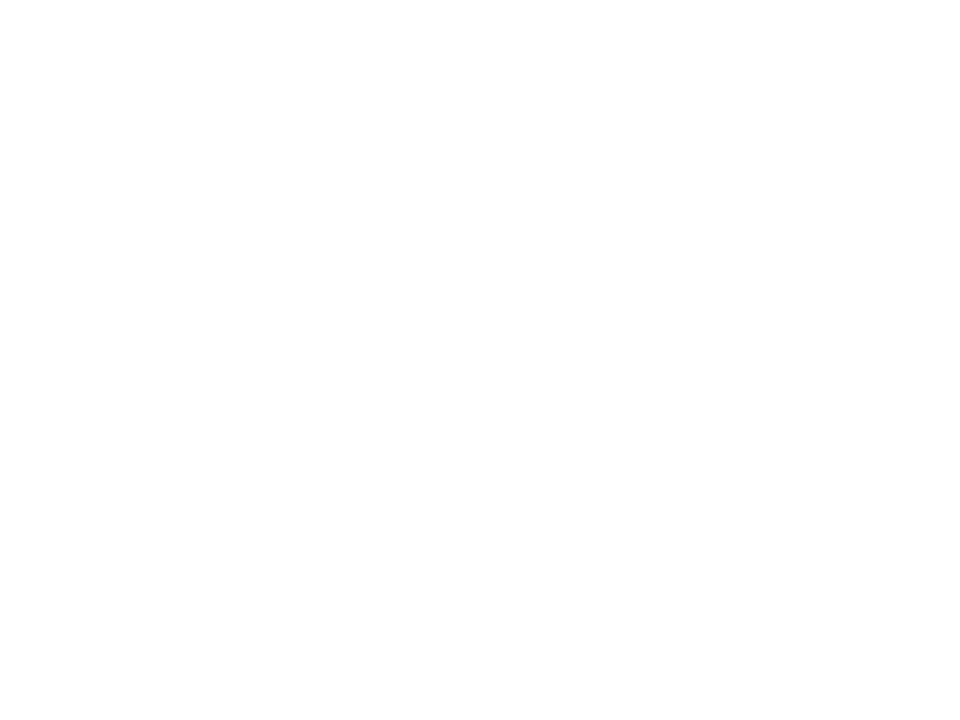

07-03 16:01 baseneuron                     DEBUG    [baseneuron.py       : 181] 	 cli set to 5
07-03 16:01 baseneuron                     DEBUG    [baseneuron.py       :  56] 	 total nseg BEFORE geom_nseg: 275
07-03 16:01 baseneuron                     DEBUG    [baseneuron.py       :  63] 	 total nseg AFTER geom_nseg: 9
07-03 16:01 baseneuron                     DEBUG    [baseneuron.py       :  64] 	 Neuron built
07-03 16:01 baseneuron                     DEBUG    [baseneuron.py       : 181] 	 cli set to 4
07-03 16:01 pynrnutils                     INFO     [pynrnutils.py       : 104] 	 steady state [Cl]_i 4.8185494442
07-03 16:01 pynrnutils                     INFO     [pynrnutils.py       : 105] 	 steady state Vm -65.0
07-03 16:01 pynrnutils                     INFO     [pynrnutils.py       : 106] 	 took 50000 ms (simulation time)
07-03 16:01 voltage_shunt_level            DEBUG    [voltage_shunt_level.py: 125] 	 inhib_n_loc_insert = [([<nrnutils.Section object at 0x7fa131c65890>], [

07-03 16:01 voltage_shunt_level            DEBUG    [voltage_shunt_level.py: 150] 	 hotspot_n_loc_insert = [([<nrnutils.Section object at 0x7fa131af6b50>], [0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595])]
07-03 16:01 baseneuron                     INFO     [baseneuron.py       : 220] 	 placing 'ampa_Tian' on '['SingleDend__nrnsec_0x404e930']' at locations [0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595]
07-03 16:01 baseneuron                     DEBUG    [baseneuron.py       : 231] 	 __nrnsec_0x404e930_ampa_Tian
07-03 16:01 voltage_shunt_level            DEBUG    [voltage_shunt_level.py: 168] 	 actual locations: [('dend_1', 0.64286), ('dend_1', 0.64286), ('dend_1', 0.64286), ('dend_1', 0.64286), ('dend_1', 0.64286), ('dend_1', 0.64286), ('dend_1', 0.64286), ('dend_1', 0.64286), ('dend_1', 0.64286), ('de

In [10]:
plot = voltage_shunt_level_plot(new_once=True)
num_exc_synapses = 20
num_inh_synapses = 20
off_path_location = 0.99
on_path_location = 0.2
hotspot_location = (off_path_location - on_path_location) / 2.0 + on_path_location
plot_df_sl_atten=False

common_netstim_args = dict(hz=20,
                            start=0,
                            noise=1,
                            duration=None,  # defaults to tstop
                            weight=1,
                            n_sources=0)

voltage_shunt_level(plot, plot_df_sl_atten=plot_df_sl_atten, v_init='auto',
                    inhib_syn_type='GABAa', exc_syn_type='ampa_Tian',
                    inhib_n_loc_insert=[off_path_location] * num_inh_synapses,
                    hotspot_n_loc_insert=[hotspot_location] * num_exc_synapses,
                    inh_netstim_args=common_netstim_args,
                    exc_netstim_args=common_netstim_args,
                    colormap='Blues', iter_label="Off-path")
voltage_shunt_level(plot, plot_df_sl_atten=plot_df_sl_atten, v_init='auto',
                    inhib_syn_type='GABAa', exc_syn_type='ampa_Tian',
                    inhib_n_loc_insert=[on_path_location] * num_inh_synapses,
                    hotspot_n_loc_insert=[hotspot_location] * num_exc_synapses,
                    inh_netstim_args=common_netstim_args,
                    exc_netstim_args=common_netstim_args,
                    colormap='Greens', iter_label="On-path")

# voltage_shunt_level(plot, v_init='auto',
#                     inhib_syn_type='GABAa', exc_syn_type='ampa_Tian',
#                     inhib_n_loc_insert=[off_path_location] * int(num_synapses / 2) +
#                                        [on_path_location] * int(num_synapses / 2),
#                     hotspot_n_loc_insert=[hotspot_location] * num_synapses,
#                     inh_netstim_args=inh_netstim_args,
#                     exc_netstim_args=inh_netstim_args,
#                     colormap='Reds', iter_label="On- and Off-path")
plt.show()

## Shunt Level Accumulation

From your Fig 4F ![sl_accumulation.png](sl_accumulation.png)

Shunt Level should be greater at a junction than at the synapse for sufficiently great number of branches. 

Here I try recreate that using a simple model (reduced parameters, no ions) and a (slightly) more complex model with GABAa and ions $K^+$ , $Na^+$ , $Cl^-$ , and $HCO_3^-$.

I've tried a number of parameters in `kwargs`, as well as in `inh_netstim_args`, plus with + without excitation (`exc_syn_type` as `None` or `ampa_Tian`).

I've also tried different morphologies, but have reduced it to as simple as possible to recreate the finding. I attempted a 2-cylinder model (not shown), but wasn't succeeding with having the simulations be the same as in the radial (`MultiDend`) model.



### create plot per simulation

In [10]:
plot = voltage_shunt_level_plot(new_once=False)

## Neuron Parameters

In [11]:
x_units = [
    settings.um, # distance from soma on x-axis of shunt-level (where soma(0.0) is 0 and soma(1.0) is L)
    'X'          # X on x-axis of shunt-level
    ][1] # choose option
 
# note that parameters in kwarg will only apply to the morphology that has that parameter
#   e.g. g_k_bar will be set in MultiDend but not MultiDendSimple (as 'k' mechanism is not present)
kwargs = {
    'radial_l': 50,
    'radial_diam': 1, 
    'g_k_bar': 5,  # default = 5
    'p_cl': 0.4,  # default = 0.4
    'g_na_bar': 2000,  # default = 2000
    'p_na': 0.23,  # default = 0.23
    'num_dendrites': 16,
    'inh_synapse_sources': 1, # default 1, 0 for each synapse to get it's own source of input
    'Ra': 100,  # default = 100
    'g_im_bar': 0.00012,  # default = 0.00012
    'g_pas_k': 0.000125,  # default = 0.000125
}
neuron_kwargs = dict(
    axon=False,
    soma=False,
    even_radial=False,
    radial_nseg=9,
    **kwargs
)


### Excitation
`exc_syn_type = None` disables excitation altogether.

Trying changing `None` to `ampa_Tian` to have excitation

In [12]:
exc_syn_type  = None
total_exc_synapses = 20
exc_synapse_location = 0.01
exc_netstim_args = dict(hz=100,
                        start=0,
                        noise=1,
                        duration=None,  # defaults to tstop
                        weight=1,
                        n_sources=0)

### Inhibition
`loc` is location of inhibition on dendrite

`inh_netstim_args` only applies when `inhib_syn_type = GABAa` 

In [13]:
loc = 0.2

inh_netstim_args = dict(hz=100,
                        start=0,
                        noise=1,
                        duration=None,  # defaults to tstop
                        weight=1, # increases strength of a single synapse (# channels activated)
                        n_sources=kwargs['inh_synapse_sources'])

## SIMPLE Model

| inhib_syn_type | neuron_class | 
|--- | --- |
| `inhfluct_simple` | `MultiDendSimple` |




In [14]:
iter_label = "simple model (no soma)"
logger.debug(iter_label)

inhib_syn_type = 'inhfluct_simple'

neuron_class = MultiDendSimple

logger.debug("running")
df_sl, df_sl_att, fig, axes = voltage_shunt_level(plot,
                                                  v_init='auto',
                                                  e_offset=-5,
                                                  inhib_syn_type=inhib_syn_type,
                                                  exc_syn_type=exc_syn_type,
                                                  inhib_n_loc_insert=[loc],
                                                  hotspot_n_loc_insert=[('dend[0]',[exc_synapse_location] * total_exc_synapses)],
                                                  inh_netstim_args=inh_netstim_args,
                                                  exc_netstim_args=exc_netstim_args,
                                                  colormap='RdYlGn',
                                                  neuron=neuron_class,
                                                  neuron_args=neuron_kwargs,
                                                  iter_label=iter_label,
                                                  x_units=x_units)
axes[1].autoscale(True)
axes[2].autoscale(True)
plt.show()

06-19 14:06 sl_accumulation                DEBUG    [<ipython-input-14-dd1e65b405e5>:   2] 	 simple model (no soma)
06-19 14:06 sl_accumulation                DEBUG    [<ipython-input-14-dd1e65b405e5>:   8] 	 running
06-19 14:06 baseneuron                     DEBUG    [baseneuron.py       : 181] 	 cli set to 5
06-19 14:06 baseneuron                     DEBUG    [baseneuron.py       :  56] 	 total nseg BEFORE geom_nseg: 144
06-19 14:06 baseneuron                     DEBUG    [baseneuron.py       :  64] 	 Neuron built
06-19 14:06 baseneuron                     DEBUG    [baseneuron.py       : 181] 	 cli set to 4
06-19 14:06 pynrnutils                     INFO     [pynrnutils.py       : 104] 	 steady state [Cl]_i 4.82144022239
06-19 14:06 pynrnutils                     INFO     [pynrnutils.py       : 105] 	 steady state Vm -65.0
06-19 14:06 pynrnutils                     INFO     [pynrnutils.py       : 106] 	 took 50000 ms (simulation time)
06-19 14:06 baseneuron                     DEBUG 

<IPython.core.display.Javascript object>